# Load Packages

In [1]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import math
from scipy.stats import skew, kurtosis

# Seaborn
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# little function for later
def isNaN(string):
    return string != string

# Plotstyle

In [2]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Load Data

In [3]:
# rawdata is direct import from excel

# Import of excel data, sheet by sheet
Data = pd.ExcelFile("Forward_data_NV.xlsx")
# Fwd_Ask_raw = pd.DataFrame(pd.read_excel(Data, 0))
Fwd_Bid_raw = pd.DataFrame(pd.read_excel(Data, 0))
Spot_Ask_raw = pd.DataFrame(pd.read_excel(Data, 1))
Spot_Bid_raw = pd.DataFrame(pd.read_excel(Data, 2))

# keep a safe copy of the rawdata to compare the changes
# Fwd_Ask_points = Fwd_Ask_raw.copy()
Fwd_Bid_points = Fwd_Bid_raw.copy()
Spot_Ask = Spot_Ask_raw.copy()
Spot_Bid = Spot_Bid_raw.copy()

# Set date as index
# Fwd_Ask_points.set_index("Dates", inplace=True)
Fwd_Bid_points.set_index("Dates", inplace=True)
Spot_Ask.set_index("Dates", inplace=True)
Spot_Bid.set_index("Dates", inplace=True)

In [4]:
Fwd_Bid_points

,EURGBP1M Curncy,EURCHF1M Curncy,EURCNY1M Curncy,EURAUD1M Curncy,EURJPY1M Curncy,EURUSD1M Curncy,EURCAD1M Curncy,EURSGD1M Curncy,EURINR1M Curncy
Dates,,,,,,,,,
2000-01-03,13.40,-27.00,NaN,30.00,-29.20,23.75,21.00,-12.00,NaN
2000-02-01,13.70,-17.50,NaN,25.00,-28.90,23.75,19.90,1.00,NaN
2000-03-01,12.90,-19.30,NaN,26.00,-29.80,20.25,17.00,-14.00,NaN
2000-04-03,11.20,-13.90,NaN,25.75,-33.10,19.10,18.50,-21.00,NaN
2000-05-01,11.20,-13.40,NaN,28.00,-34.00,18.60,18.00,-19.00,NaN
...,...,...,...,...,...,...,...,...,...
2023-01-02,12.80,-13.08,-9.33,15.32,-27.19,24.83,29.50,25.25,35.67
2023-02-01,10.33,-12.64,-5.90,9.98,-28.31,19.52,23.33,16.53,28.68
2023-03-01,10.98,-15.57,-22.19,10.99,-36.32,19.57,22.52,14.42,31.69


In [5]:
# Divide Forward Points by 10000 to get them in decimals --> 1 forward point = 0.01% = 0.00001
# Fwd_Ask = Fwd_Ask_points / 1000
Fwd_Bid = Fwd_Bid_points / 10000
# Japan * 100
# Fwd_Ask.loc[:,"EURJPY1M Curncy"] = Fwd_Ask.loc[:,"EURJPY1M Curncy"] * 100
Fwd_Bid.loc[:,"EURJPY1M Curncy"] = Fwd_Bid.loc[:,"EURJPY1M Curncy"] * 100 # muesmer das mache? USD isch ja auso höch

In [6]:
Spot_Bid.columns = Fwd_Bid.columns
FX1M_Bid = Fwd_Bid.add(Spot_Bid, fill_value=0) # Forward Price is Spot Price + Future Points in decimals
#FX1M_Ask = Fwd_Ask.add(Spot_Ask, fill_value=0) # Forward Price is Spot Price + Future Points in decimals

In [7]:
# Forward Price Adjustments -> add TC for futures above Bid-Ask to resemble UBS rates and tenureTC
# Prep
sptTC_bps = 60 # Annualized extra transaction cost due to UBS broker
fwdTC_bps = 10 # Annualized extra transaction cost due to UBS broker
fwd_sign = 1 # 1 means going long the forward, -1 means going short the forward
spt_sign = -1 # 1 Glattstellen von Forward = taking opposite position
tenure_contracts = 1 # in months

Tenure_multiplier = tenure_contracts / 12 # approx to get fwdTC_bps and sptTC_bps relative to the duration (UBS calculates it like this)
SpotTC = sptTC_bps / 10000
ForwardTC = fwdTC_bps / 10000
# Adjusting FX1M & Spot
Spot = Spot_Ask * (1 + ((SpotTC * Tenure_multiplier) * spt_sign))
Forward = FX1M_Bid * (1 + (((ForwardTC * Tenure_multiplier) + (SpotTC * Tenure_multiplier)) * fwd_sign))


In [8]:
Forward.iloc[:-2,:]

,EURGBP1M Curncy,EURCHF1M Curncy,EURCNY1M Curncy,EURAUD1M Curncy,EURJPY1M Curncy,EURUSD1M Curncy,EURCAD1M Curncy,EURSGD1M Curncy,EURINR1M Curncy
Dates,,,,,,,,,
2000-01-03,0.627406,1.603135,8.408902,1.558909,103.678444,1.027074,1.484565,1.699291,44.021664
2000-02-01,0.602821,1.608388,8.053595,1.538997,104.521936,0.973943,1.409512,1.650962,42.259937
2000-03-01,0.615049,1.606006,8.017574,1.609338,104.032650,0.975494,1.412724,1.668673,42.298660
2000-04-03,0.599369,1.579231,7.920618,1.572392,99.767164,0.957668,1.387059,1.638855,41.585244
2000-05-01,0.590544,1.564372,7.920618,1.573597,99.327907,0.917995,1.356871,1.565913,39.884452
...,...,...,...,...,...,...,...,...,...
2022-11-01,0.861531,0.986477,7.192932,1.546433,146.250863,0.990006,1.349064,1.400844,82.174910
2022-12-01,0.859712,0.984747,7.403712,1.545181,142.072828,1.054600,1.415686,1.426306,84.851046
2023-01-02,0.886467,0.983966,7.351753,1.568697,138.859054,1.069406,1.450095,1.432760,88.412011


In [9]:
Spot.iloc[1:-1,:]

,EURGBP Curncy,EURCHF Curncy,EURCNY Curncy,EURAUD Curncy,EURJPY Curncy,EURUSD Curncy,EURCAD Curncy,EURSGD Curncy,EURINR Curncy
Dates,,,,,,,,,
2000-01-31,0.600899,1.608096,8.096550,1.522938,104.207870,0.970415,1.405397,1.649875,42.803388
2000-02-29,0.610794,1.605397,7.968314,1.560719,106.326810,0.963918,1.397301,1.661169,42.483448
2000-03-31,0.600500,1.591004,7.919538,1.573813,98.190880,0.955222,1.384208,1.635582,41.718230
2000-04-28,0.587736,1.564277,7.542527,1.561979,98.560695,0.911544,1.348985,1.556721,39.771804
2000-05-31,0.624688,1.575412,7.756220,1.635682,100.879535,0.937731,1.403098,1.623988,41.797091
...,...,...,...,...,...,...,...,...,...
2022-11-30,0.862828,0.984008,7.333032,1.532883,143.718105,1.040380,1.395682,1.417891,84.331213
2022-12-30,0.886596,0.991074,7.362017,1.574562,140.629650,1.070964,1.453773,1.437581,88.134911
2023-01-31,0.881579,0.995102,7.342927,1.539850,141.339295,1.086057,1.445647,1.427486,88.704626


In [10]:
# Calculating Forward Hedge Returns
# BoM Long Forward Price / EoM Short SpotPrice
Hedge_return = np.divide(Forward.iloc[:-2,:] , Spot.iloc[1:-1,:]) -1

# inserting 4 rows at the beginning for the EUR currencies
EUR_currencies = pd.DataFrame(0, columns = ["Germany", 'France', 'Spain', 'Italy'], index = Hedge_return.index)
EUR_currencies
Hedge_return = pd.concat([EUR_currencies, Hedge_return], axis = 1)

<ipython-input-10-2bc16e8814b8>:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  Hedge_return = np.divide(Forward.iloc[:-2,:] , Spot.iloc[1:-1,:]) -1


In [11]:
Hedge_return

,Germany,France,Spain,Italy,EURGBP1M Curncy,EURCHF1M Curncy,EURCNY1M Curncy,EURAUD1M Curncy,EURJPY1M Curncy,EURUSD1M Curncy,EURCAD1M Curncy,EURSGD1M Curncy,EURINR1M Curncy
Dates,,,,,,,,,,,,,
2000-01-03,0,0,0,0,0.044111,-0.003085,0.038578,0.023619,-0.005080,0.058387,0.056332,0.029951,0.028462
2000-02-01,0,0,0,0,-0.013054,0.001863,0.010703,-0.013918,-0.016975,0.010400,0.008739,-0.006144,-0.005261
2000-03-01,0,0,0,0,0.024228,0.009429,0.012379,0.022573,0.059494,0.021222,0.020601,0.020232,0.013913
2000-04-03,0,0,0,0,0.019794,0.009559,0.050128,0.006667,0.012241,0.050600,0.028224,0.052761,0.045596
2000-05-01,0,0,0,0,-0.054656,-0.007008,0.021196,-0.037956,-0.015381,-0.021046,-0.032946,-0.035761,-0.045760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,0,0,0,0,-0.001503,0.002509,-0.019105,0.008839,0.017623,-0.048418,-0.033401,-0.012023,-0.025569
2022-12-01,0,0,0,0,-0.030323,-0.006384,0.005664,-0.018660,0.010262,-0.015280,-0.026198,-0.007843,-0.037260
2023-01-02,0,0,0,0,0.005544,-0.011191,0.001202,0.018734,-0.017548,-0.015331,0.003077,0.003695,-0.003299


In [12]:
Hedge_return.to_excel("Forward_long_hedge.xlsx", sheet_name='Fwd_Returns') 

<ipython-input-12-43f98a592f04>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  Hedge_return.to_excel("Forward_long_hedge.xlsx", sheet_name='Fwd_Returns')


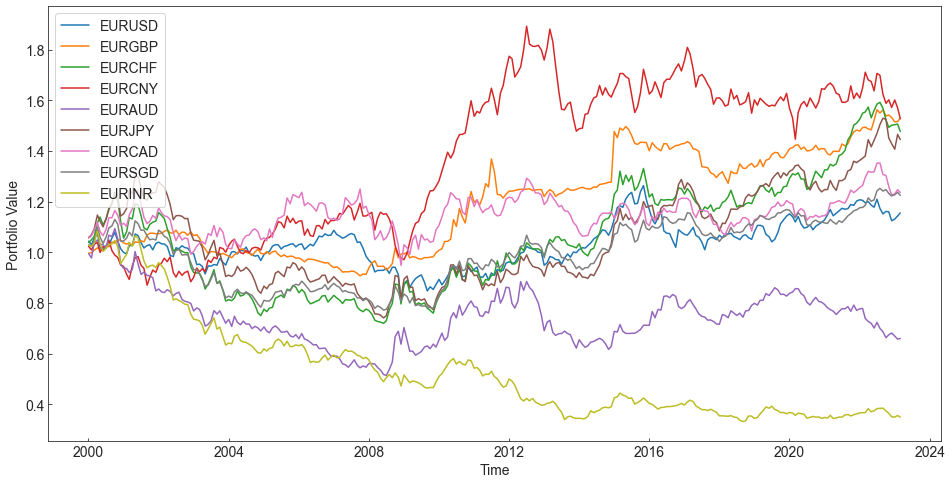

In [16]:
# Plot Strategy Performances
Hedge_returnNAV = np.cumprod(1 + Hedge_return)
# Create the line plot
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,0+4], label='EURUSD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,1+4], label='EURGBP')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,2+4], label='EURCHF')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,3+4], label='EURCNY')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,4+4], label='EURAUD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,5+4], label='EURJPY')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,6+4], label='EURCAD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,7+4], label='EURSGD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,8+4], label='EURINR')

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

In [14]:
# where japan is weird:
Hedge_returnNAV.iloc[119:,[5,8]]
# where india is weird:
Hedge_returnNAV.iloc[145:,[5,8]]

,EURCHF1M Curncy,EURJPY1M Curncy
Dates,,
2012-02-01,1.241860,0.798169
2012-03-01,1.244274,0.779680
2012-04-02,1.247680,0.807305
2012-05-01,1.248885,0.884477
2012-06-01,1.249376,0.849647
...,...,...
2022-11-01,1.542527,0.674417
2022-12-01,1.532679,0.681338
2023-01-02,1.515527,0.669381


In [15]:
# Lucas Function
def FXReturn(Spot_dta, Forward_dta, fwdTC_bps, sptTC_bps, tenureTC, fwd_sign, spt_sign):
    Tenure_multiplier = tenureTC / 12
    SpotTC = sptTC_bps / 10000
    ForwardTC = fwdTC_bps / 10000

    Spot = pd.DataFrame(Spot_dta)
    Spot_date = Spot.index
    Spot = Spot.apply(pd.to_numeric, errors='coerce').fillna(0)
    #Spot = Spot.iloc[:, :-3]

    Forward = pd.DataFrame(Forward_dta)
    Forward = Forward.apply(pd.to_numeric, errors='coerce').fillna(0)
    #Forward = Forward.iloc[:, :-3]

    Spot = Spot * (1 + ((SpotTC * Tenure_multiplier) * spt_sign))
    Forward = Forward * (1 + (((ForwardTC * Tenure_multiplier) + (SpotTC * Tenure_multiplier)) * fwd_sign))
    Return = Forward / Spot #Spot in t and Forward in t-30 or Spot EOM and Forward BOM

    Return = Return.replace([np.inf, -np.inf, np.nan], np.nan)
    Return[Return == 0] = np.nan
    Return = pd.DataFrame(Return - 1, index=Spot_date)

    return Return